In [26]:
# 실행 결과
# - Pix2Pix 모델 다운로드
# - GAN 학습을 위한 기본적인 환경 구축
import urllib.request
import zipfile
import os
import sys

repo_url = "https://github.com/tensorflow/examples/archive/refs/heads/master.zip"
urllib.request.urlretrieve(repo_url, "tensorflow_examples.zip")

with zipfile.ZipFile("tensorflow_examples.zip", "r") as zip_ref:
    zip_ref.extractall(".")

if os.path.exists("examples"):
    os.system("rm -rf examples")
os.rename("examples-master", "examples")

sys.path.append("./examples")

from tensorflow_examples.models.pix2pix import pix2pix  # jupyter notebook에서는 나올 수밖에 없음

print(dir(pix2pix))


['AUTOTUNE', 'FLAGS', 'IMG_HEIGHT', 'IMG_WIDTH', 'InstanceNormalization', 'Pix2pix', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'absolute_import', 'app', 'create_dataset', 'discriminator', 'division', 'downsample', 'flags', 'get_checkpoint_prefix', 'load', 'load_image_test', 'load_image_train', 'main', 'normalize', 'os', 'print_function', 'random_crop', 'random_jitter', 'resize', 'run_main', 'tf', 'time', 'unet_generator', 'upsample']


In [27]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix  # jupyter notebook에서는 나올 수밖에 없음
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE


In [28]:
# 실행 결과
# - 데이터셋 불려오기
# - Horse 훈련, 테스트 데이터와 zebra 훈련, 테스트 데이터 분리
# - Batch, buffer size 및 이미지 크기 설정

dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [29]:
# 실행 결과
# - 딥러닝 모델 학습 . 안정성 향상을 위한 이미지 데이터 정규화
def normalize(image):
  image = tf.cast(image, tf.float32) # tf: 실수형 숫자로 바꿔주는거
  image = (image / 127.5) - 1
  return image

In [30]:
# 실행 결과
# - GAN 모델에서 이미지 데이터 증강 정의
        # >> 사진이 많아지면 더 똑똑해지지만, 적으면 데이터를 더 많이 보이게 해야하기 때문
# - Resizing, 좌우 반전 및 random cropping
def random_crop(image):
    return tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

def random_jitter(image):
    image = tf.image.resize(image, [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image = random_crop(image)

    image = tf.image.random_flip_left_right(image)
    return image



In [31]:
# 실행 결과
# - 이미지 데이터를 학습에 적합한 형태로 전처리하는 역할
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image


In [32]:
# 실행 결과
# - test 데이터에 대해 전처리를 수행하는 역할
def preprocess_image_test(image, label):
  image = normalize(image)
  return image


In [33]:
# 학습용 데이터 (정상 순서)
train_horses = train_horses.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
train_horses = train_horses.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
train_zebras = train_zebras.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 테스트용 데이터 (shuffle 제거, cache는 optional)
test_horses = test_horses.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
test_horses = test_horses.cache().batch(BATCH_SIZE)

test_zebras = test_zebras.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
test_zebras = test_zebras.cache().batch(BATCH_SIZE)

In [34]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))



2025-07-26 16:30:35.082944: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-07-26 16:30:36.323233: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-26 16:30:36.330777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `datas

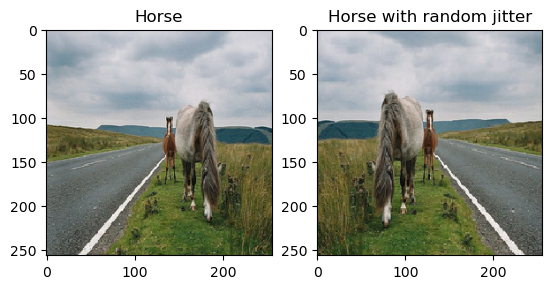

In [42]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)


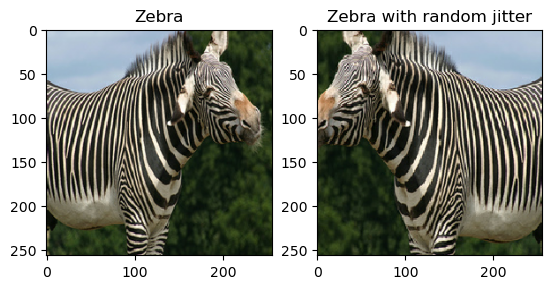

In [43]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)